# Initalize libraries

## Import libraries

In [1]:
import sys, os
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser
import xarray as xr
import h5py
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

# Misc
from scipy.ndimage import gaussian_filter1d

# Open nexus files
from nexusformat.nexus import *

# Self-written libraries
sys.path.append(join(os.getcwd(),"library"))
import support_functions as sup

# Gifs
import imageio

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

In [2]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU available


In [3]:
# interactive plotting
import ipywidgets
%matplotlib widget

# Auto formatting of cells
%load_ext jupyter_black

## Experiment specific Functions

In [4]:
PROPOSAL = 11017626
USER = getuser()

In [5]:
BASEFOLDER = "/asap3/petra3/gpfs/p04/2023/data/%s/" % PROPOSAL
subfolder = "2311_SAXS"
sample_name = "2311_setup"


# Load any kind of data from collection
def load_collection(scan_id, field):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["instrument"]["collection"][field][()])
        print("Loaded: %s" % (fname))
    return np.squeeze(data)


# Load mono energy
def load_energy(scan_id):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["instrument"]["monochromator"]["energy"][()])
        print("Loaded: %s" % (fname))
    return np.squeeze(data)


# Load any kind of data from measurements
def load_data(scan_id, field):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = np.array(f["scan"]["data"][field][()])
        print("Loaded key %s of %s" % (field, fname))
    return np.squeeze(data)

In [6]:
# Not implemented yet
def norm_hyst_data(ydata, norm):
    """
    Normalize hysteresis yaxis to +/- 1
    """
    ynorm = []
    for i in range(len(ydata)):
        tmp = ydata[i] / norm[i]
        tmp = tmp - np.mean(tmp[-5:])
        tmp = tmp / np.mean(tmp[:5])
        tmp = 2 * (tmp - 0.5)
        ynorm.append(tmp)

    return ynorm

# Experimental Details

In [7]:
# Dict with basic experimental parameter
experimental_setup = {}

# General saving folder
folder_general = sup.create_folder(join(BASEFOLDER, "processed"))
print("Output Folder: %s" % folder_general)

Output Folder: /asap3/petra3/gpfs/p04/2023/data/11017626/processed


# Single Diode scans

In [66]:
# Add scan numbers to combine in single plot
scan_ids = [1948, 1949]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "br1_master"
data_key_y = "adc_beck_femto_diodemax_mean"

# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = True
data_key_norm = "adc_beck_femto_goldmesh_mean"  # "petra_curr"


# Load energy/wavelength and add to experimental setup
experimental_setup["energy"] = np.array(load_energy(scan_ids[0]))
experimental_setup["lambda"] = cci.photon_energy_wavelength(
    experimental_setup["energy"], input_unit="eV"
)

# Load data
xdata, ydata, norm = [], [], []
for scan_id in tqdm(scan_ids):
    xdata.append(load_data(scan_id, data_key_x))
    ydata.append(load_data(scan_id, data_key_y))

    if normalization is True:
        norm.append(load_data(scan_id, data_key_norm))
    else:
        norm.append(np.ones(load_data(scan_id, data_key_y).shape))

Loaded: /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01948.nxs


  0%|          | 0/2 [00:00<?, ?it/s]

Loaded key br1_master of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01948.nxs
Loaded key adc_beck_femto_diodemax_mean of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01948.nxs
Loaded key adc_beck_femto_goldmesh_mean of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01948.nxs
Loaded key br1_master of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01949.nxs
Loaded key adc_beck_femto_diodemax_mean of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01949.nxs
Loaded key adc_beck_femto_goldmesh_mean of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01949.nxs


Saving: /asap3/petra3/gpfs/p04/2023/data/11017626/processed/ScanId_1948-1949_Diode_cklose.png


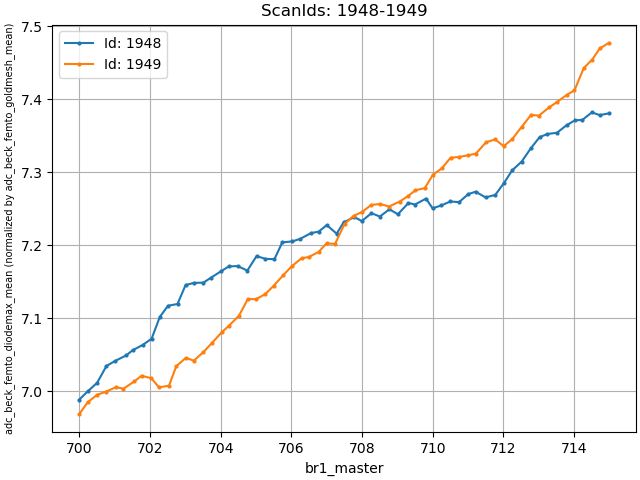

In [67]:
# Format title and output file name
if len(scan_ids) > 1:
    title = "ScanIds: %04d-%04d" % (scan_ids[0], scan_ids[-1])
    fname = join(
        folder_general,
        "ScanId_%04d-%04d_Diode_%s.png" % (scan_ids[0], scan_ids[-1], USER),
    )
else:
    title = "ScanId: %04d" % (scan_ids[0])
    fname = join(folder_general, "ScanId_%04d_Diode_%s.png" % (scan_ids[0], USER))


# Plot all scans together
fig, ax = plt.subplots()

# Iterate over scans
for i, _ in enumerate(scan_ids):
    ax.plot(
        xdata[i],
        ydata[i] / norm[i],
        "o-",
        markersize=2,
        label="Id: %d" % scan_ids[i],
    )

# Plotting options
ax.set_title(title)
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])
ax.grid()
ax.legend()

# Different label with and without normalization
if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm, fontsize=7)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")

# Save plot
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

# Diode Trace Hysteresis

In [47]:
def ramp_tan(npts: int, s: float, full=False):
    """Calculate truncated tangent ramp function.

    Parameters
    ==========
    npts: int
        Number of points to calculate
    s: float
        shape parameter (0<s≤1) varies curve from linear (s→0) to tan-shaped
    full: bool
        If True, return both arms of the loop by mirroring. This effectively
        doubles the number of points.

    Returns
    =======
    ramp: np.ndarray
        normalized ramp values
    """
    # if (s <= 0) or (s > 1):
    #     raise ValueError("shape parameter out of range 0<s≤1")
    x = s * np.linspace(-np.pi / 2, np.pi / 2, npts)
    y = np.tan(x) / np.tan(np.pi * s / 2)
    if full:
        y = np.append(y, y[::-1][1:])
    return y

In [48]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [53]:
# Choose scan id
scan_id = 1940

# Load trace data
fields = [
    f"adc_beck_femto_diodemax_trace",
    "adc_beck_femto_goldmesh_trace",
    "adc_beck_mtesla_trace",
]
adcs = [load_data(scan_id, f) for f in fields]

Loaded key adc_beck_femto_diodemax_trace of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01940.nxs
Loaded key adc_beck_femto_goldmesh_trace of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01940.nxs
Loaded key adc_beck_mtesla_trace of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01940.nxs


In [54]:
# Create xarray dataset
ds = xr.Dataset()
ds["fields"] = ("index", adcs[2][:, 10:-10].flatten())  # magnetic field
ds["diode"] = ("index", adcs[0][:, 10:-10].flatten())  # diode current
ds["mesh"] = ("index", adcs[1][:, 10:-10].flatten())  # mesh current for normalization
ds["rising"] = (
    "index",
    gaussian_filter1d(np.gradient(ds["fields"]), 20) > 0,
)  # which hysteresis branch

In [55]:
bins = np.max(ds.fields.values) * ramp_tan(100, 0.1, False)

ds_sel = ds
# ds_fit = ds.sel(index=range(9000))
ds_sel["rising"] = ds_sel.rising.astype(bool)
up = ds_sel.where(ds_sel.rising).groupby_bins("fields", bins).mean()
down = ds_sel.where(~ds_sel.rising).groupby_bins("fields", bins).mean()

Saving: /asap3/petra3/gpfs/p04/2023/data/11017626/processed/ScanId_1940_Diode_Trace_cklose.png


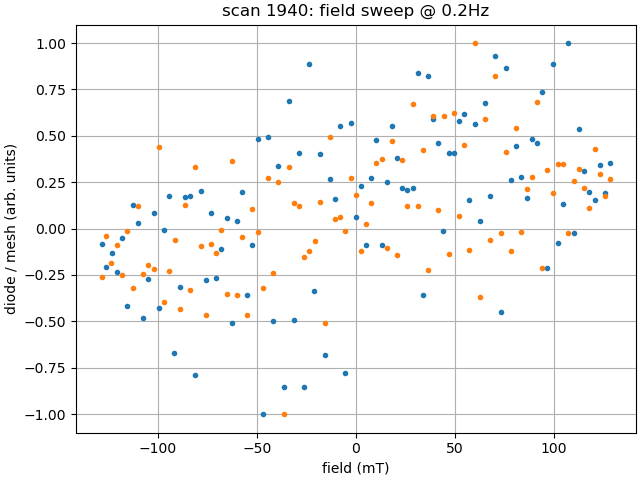

In [56]:
fig, ax = plt.subplots()
ax.plot(1e2 * up.fields, 2 * normalize(up.diode / up.mesh) - 1, "o", ms=3)
ax.plot(1e2 * down.fields, 2 * normalize(down.diode / down.mesh) - 1, "o", ms=3)
ax.set_xlabel("field (mT)")
ax.set_ylabel("diode / mesh (arb. units)")
ax.set_title("scan %d: field sweep @ 0.2Hz" % (scan_id))
ax.grid()

fname = join(folder_general, "ScanId_%04d_Diode_Trace_%s.png" % (scan_id, USER))
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

# Individal Diode Traces (not updated)

In [31]:
scan_ids = [1611]
data_key_x = "mono_energy_mean"
data_key_y = "adc_beck_femto_diodemax_trace"

xdata = []
ydata = []
for scan_id in tqdm(scan_ids):
    xdata.append(np.array(load_data(scan_id, data_key_x)))
    ydata.append(np.array(load_data(scan_id, data_key_y)))

xdata = np.squeeze(np.array(xdata))
ydata = np.squeeze(np.array(ydata))

  0%|          | 0/1 [00:00<?, ?it/s]

Loaded key mono_energy_mean of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01611.nxs
Loaded key adc_beck_femto_diodemax_trace of /asap3/petra3/gpfs/p04/2023/data/11017626/raw/2311_SAXS/2311_setup_01611.nxs


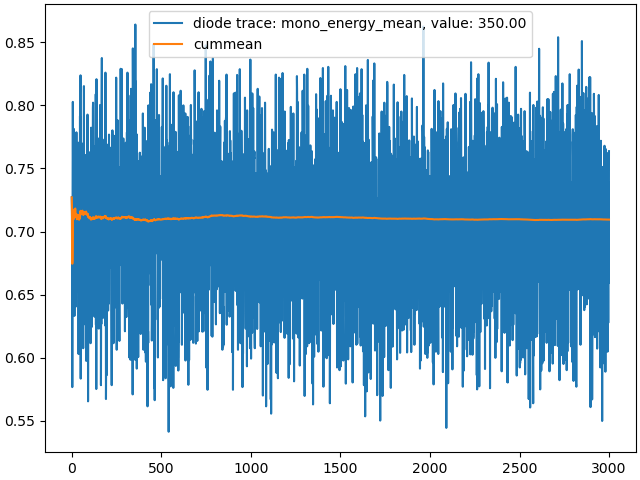

In [35]:
fig, ax = plt.subplots()
for i in range(0, 1):
    data_trace = ydata[i]
    cummean = np.cumsum(data_trace) / np.cumsum(np.ones(data_trace.shape))
    ax.plot(
        data_trace,
        label="diode trace: %s, value: %.2f" % (data_key_x, np.round(xdata[i], 2)),
    )
    ax.plot(cummean, label="cummean")
    ax.legend()

(0.0, 50.0)

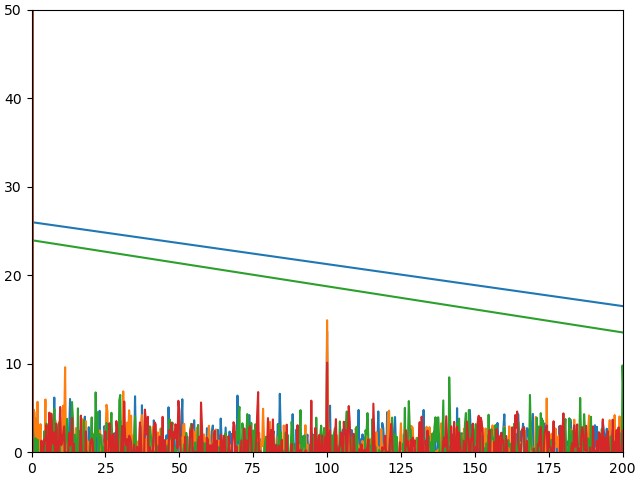

In [34]:
fig, ax = plt.subplots()
for i in range(0, 4):
    # time = np.arange(0, data_trace.shape[0]).astype(int)  # in s
    ax.plot(np.fft.fftfreq(data_trace.shape[0], 1e-3), np.fft.fft(ydata[i]))
ax.set_xlim([0, 200])
ax.set_ylim([0, 50])

ValueError: x and y must have same first dimension, but have shapes (161,) and (3000,)

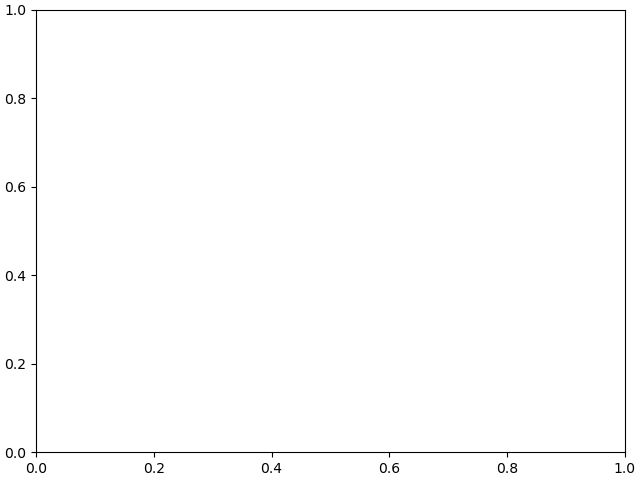

In [37]:
fig, ax = plt.subplots()

for i, _ in enumerate(scan_ids):
    ax.plot(xdata, ydata[i], "o-", markersize=1)
ax.set_title("ImId: %04d-%04d" % (scan_ids[0], scan_ids[-1]))
ax.set_xlabel(data_key_x)
ax.set_ylabel(data_key_y)
ax.grid()

fname = join(
    folder_general, "ImId_%04d-%04d_Diode_%s.png" % (scan_ids[0], scan_ids[-1], USER)
)
print("Saving: %s" % fname)
# plt.savefig(fname)